In [458]:
!pip install pyswarm colorama tabulate folium

In [459]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tabulate import tabulate
import folium
from colorama import Fore, Style, init
from IPython.display import display
from geopy.distance import geodesic
from datetime import datetime
from pyswarm import pso  # Particle Swarm Optimization

# Initialize colorama for nice console output
init()

# Print execution info
print(f"Execution Date and Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"User: kripa-sindhu-007\n")

Execution Date and Time: 2025-03-27 06:08:08
User: kripa-sindhu-007



In [460]:
# Vehicle parameters as defined in De Nunzio et al. (2016)
VEHICLE_PARAMETERS = {
    "mass": 1190,  # Mass of the vehicle (kg)
    "wheel_radius": 0.2848,  # Wheel radius (meters)
    "transmission_ratio": 5.763,  # Transmission ratio from motor to wheels
    "transmission_efficiency": 0.95,  # Transmission efficiency coefficient
    "drive_efficiency": 0.95,  # Powertrain efficiency coefficient
    "a0": 125.73,  # Rolling resistance coefficient (N)
    "a1": 1.72,  # First-order drag coefficient (N/(m/s))
    "a2": 0.58,  # Second-order drag coefficient (N/(m/s)^2)
    "motor_min_torque": -50,  # Minimum motor torque (Nm)
    "motor_max_torque": 200,  # Maximum motor torque (Nm)
    "acceleration": 1.5,  # Standard acceleration (m/s²)
    "air_density": 1.225,  # Air density at sea level (kg/m^3)
    "gravity": 9.81,  # Gravity constant (m/s²)
    "battery_capacity": 100,  # kWh
    "initial_charge": np.random.uniform(40, 95),   # kWh (start with 95% charge)
    "min_charge": 20,         # kWh (minimum desired battery level)
    "cost_per_kwh": .60,    # $ per kWh for charging
    "green_zone_penalty": .5 # $ penalty for not using green zones when possible
    # "running_cost_per_km": 0.0004  # $ per km for maintenance, tire wear, etc.
}

In [461]:
def calculate_route_costs(path, graph, vehicle_params, charging_stations_used=None):
    """
    Standardized cost calculator for EV routing algorithms.
    Can be used by any routing algorithm to ensure consistent cost calculation.

    Parameters:
        path (list): List of node IDs representing the route
        graph (nx.Graph): Road network graph
        vehicle_params (dict): Vehicle parameters including battery capacity
        charging_stations_used (list, optional): List of charging stations visited on the route

    Returns:
        dict: All cost metrics and relevant statistics for the route
    """
    # Initialize metrics
    total_distance = 0
    total_time = 0
    total_energy = 0
    energy_cost = 0
    running_cost = 0
    green_zone_penalties = 0
    remaining_charge = vehicle_params["initial_charge"]

    # Calculate path metrics excluding charging operations
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]

        # Energy consumption
        edge_energy = graph[u][v]['energy']
        total_energy += edge_energy
        remaining_charge -= edge_energy

        # Energy cost (direct cost of electricity used)
        energy_cost += edge_energy * vehicle_params["cost_per_kwh"]

        # Travel time
        total_time += graph[u][v]['travel_time']

        # Distance
        edge_distance = graph[u][v]['length']
        total_distance += edge_distance

        # Running cost (maintenance, tire wear, etc.)
        # if "running_cost_per_km" in vehicle_params:
        #     running_cost += edge_distance * vehicle_params["running_cost_per_km"]

        # Green zone penalties
        if not graph[u][v].get('green_zones', False):
            green_zone_penalties += vehicle_params["green_zone_penalty"]

    # Initialize charging-related costs
    charging_cost = 0
    v2g_incentives = 0
    charging_time = 0

    # Process charging station visits if provided
    if charging_stations_used:
        # Simulate the route again, but this time process charging at specified stations
        current_charge = vehicle_params["initial_charge"]

        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]

            # Calculate energy used on this edge
            edge_energy = graph[u][v]['energy']
            current_charge -= edge_energy

            # If this is a charging station that we use, simulate charging
            if v in charging_stations_used:
                station_node = graph.nodes[v]

                # Estimate energy needed to reach destination from here
                energy_to_destination = 0
                remaining_path_index = path.index(v) + 1

                for j in range(remaining_path_index, len(path) - 1):
                    p, q = path[j], path[j + 1]
                    energy_to_destination += graph[p][q]['energy']

                # Add 10% safety buffer
                required_energy = energy_to_destination * 1.1

                # Calculate target charge level
                target_charge = min(
                    required_energy + vehicle_params["min_charge"],
                    vehicle_params["battery_capacity"] * 0.8  # Don't charge beyond 80% unless necessary
                )

                # If below target, charge the vehicle
                if current_charge < target_charge:
                    charge_amount = min(
                        target_charge - current_charge,
                        station_node.get('initial_charge', 40)
                    )

                    current_charge += charge_amount

                    # Calculate charging time and cost
                    charge_rate = station_node.get('charging_rate', 7)  # kW
                    station_charging_time = charge_amount / charge_rate  # hours
                    charging_time += station_charging_time
                    charging_cost += charge_amount * vehicle_params["cost_per_kwh"]

                # If V2G is enabled and we have excess energy, give some back
                # Use a 15 kWh buffer as excess threshold
                elif station_node.get('v2g_enabled', True) and current_charge > (required_energy + 15):
                    # Calculate excess energy above required level plus 15 kWh buffer
                    excess_energy = current_charge - (required_energy + 15)
                    v2g_amount = min(excess_energy, station_node.get('charging_capacity', 100))  # Cap discharge

                    if v2g_amount > 3:  # Only discharge if significant
                        current_charge -= v2g_amount
                        incentive_rate = station_node.get('incentive_rate', 1.2 * vehicle_params["cost_per_kwh"])
                        v2g_incentives += v2g_amount * incentive_rate
                        print(f"V2G Activated at {v}: Discharged {v2g_amount} kWh, Incentives Earned: {v2g_incentives}")

    # Calculate final total cost
    total_cost = energy_cost + running_cost + charging_cost - v2g_incentives + green_zone_penalties

    # Create comprehensive metrics dictionary
    metrics = {
        "distance": total_distance,
        "time": total_time + charging_time,  # Include charging time in total
        "energy": total_energy,
        "energy_cost": energy_cost,
        "running_cost": running_cost,
        "charging_cost": charging_cost,
        "v2g_incentives": v2g_incentives,
        "green_zone_penalties": green_zone_penalties,
        "total_cost": total_cost,
        "remaining_charge": remaining_charge,
        "charging_stations_visited": charging_stations_used if charging_stations_used else [],
        "charging_time": charging_time
    }

    # Add warning if battery might deplete
    if remaining_charge < vehicle_params["min_charge"]:
        metrics["warning"] = "Battery might deplete before reaching destination"

    return metrics

In [462]:
def compute_section_energy(length, speed, grade, vehicle_params, acceleration=0):
    """
    Compute energy consumption for a road section based on the De Nunzio model

    Parameters:
        length (float): Road section length in meters
        speed (float): Speed in m/s
        grade (float): Road grade (slope) as a decimal (e.g., 0.03 for 3%)
        vehicle_params (dict): Dictionary of vehicle parameters
        acceleration (float): Acceleration in m/s²

    Returns:
        float: Energy consumption in kWh
    """
    # Avoid division by zero
    if speed <= 0:
        return 0

    # Calculate forces
    rolling_force = vehicle_params["a0"] + vehicle_params["a1"] * speed + vehicle_params["a2"] * speed**2
    slope_force = vehicle_params["mass"] * vehicle_params["gravity"] * grade
    inertial_force = vehicle_params["mass"] * acceleration

    # Total force at wheels
    total_force = rolling_force + slope_force + inertial_force

    # Motor torque and power calculation
    wheel_radius = vehicle_params["wheel_radius"]
    transmission_ratio = vehicle_params["transmission_ratio"]
    transmission_efficiency = vehicle_params["transmission_efficiency"]

    if total_force >= 0:
        # Traction phase (positive force)
        motor_torque = total_force * wheel_radius / (transmission_ratio * transmission_efficiency)
    else:
        # Regenerative braking (negative force)
        motor_torque = total_force * wheel_radius * transmission_efficiency / transmission_ratio

    # Ensure motor torque is within limits
    motor_torque = max(vehicle_params["motor_min_torque"], min(vehicle_params["motor_max_torque"], motor_torque))

    # Calculate motor speed and power
    motor_speed = speed * transmission_ratio / wheel_radius
    motor_power = motor_torque * motor_speed

    # Battery power demand with efficiency consideration
    drive_efficiency = vehicle_params["drive_efficiency"]
    if motor_power >= 0:
        # Power consumption
        battery_power = motor_power / drive_efficiency
    else:
        # Regenerative braking
        battery_power = motor_power * drive_efficiency

    # Calculate travel time and energy
    travel_time = length / speed  # seconds
    energy_joules = battery_power * travel_time  # Joules
    energy_kwh = energy_joules / 3600000  # Convert to kWh

    return energy_kwh

In [463]:
def generate_road_network(num_nodes=400, num_edges=1200, seed=42, num_charging_stations=20, num_green_zones=5):
    """
    Generate a synthetic road network with charging stations and green zones.

    Parameters:
        num_nodes (int): Number of nodes (intersections)
        num_edges (int): Number of edges (roads)
        seed (int): Random seed for reproducibility
        num_charging_stations (int): Number of charging stations to add
        num_green_zones (int): Number of green zones in the city

    Returns:
        nx.Graph: NetworkX graph representing the road network
    """
    # Set random seed for reproducibility
    np.random.seed(seed)
    random.seed(seed)

    # Create a grid-like graph to represent an urban environment
    grid_size = int(np.sqrt(num_nodes))
    road_network = nx.grid_2d_graph(grid_size, grid_size)

    # Convert the grid to a proper road network
    road_network = nx.convert_node_labels_to_integers(road_network)

    # Assign geographic coordinates to each node
    # Metro city is roughly 30km x 30km
    city_size = 30000  # 30 km in meters
    pos = {}
    for i in range(road_network.number_of_nodes()):
        row = i // grid_size
        col = i % grid_size
        # Add some randomness to make it look more natural
        jitter = np.random.normal(0, 200, 2)  # 200m standard deviation
        pos[i] = [
            (row * city_size / (grid_size - 1)) + jitter[0],
            (col * city_size / (grid_size - 1)) + jitter[1]
        ]

    # Set node positions as attributes
    nx.set_node_attributes(road_network, pos, 'pos')

    # Add charging stations to random nodes
    charging_station_nodes = random.sample(list(road_network.nodes()), num_charging_stations)
    for node in road_network.nodes():
        if node in charging_station_nodes:
            road_network.nodes[node]['charging_station'] = True
            road_network.nodes[node]['charging_capacity'] = 200  # kWh available
            road_network.nodes[node]['initial_charge'] = np.random.uniform(70, 100)  # initial charge of charging station
            road_network.nodes[node]['charging_rate'] = np.random.uniform(50, 150)  # kW (charging speed)
            road_network.nodes[node]['v2g_enabled'] = True  # Vehicle-to-Grid capability
            road_network.nodes[node]['incentive_rate'] = 1  # $ per kWh for V2G
        else:
            road_network.nodes[node]['charging_station'] = False

    # Define green zones (circular areas centered around selected charging stations)
    green_zones = []
    selected_charging_stations = random.sample(charging_station_nodes, min(num_green_zones, num_charging_stations))
    for station in selected_charging_stations:
        # Create a random circular zone centered around the charging station
        center_x, center_y = pos[station]
        radius = np.random.uniform(1000, 2000)  # 1-3 km radius
        green_zones.append({
            'center': (center_x, center_y),
            'radius': radius,
            'penalty': 0.5  # $ penalty for not using green zones
        })

    # Store green zones as a graph attribute
    road_network.graph['green_zones'] = green_zones

    # Add random edges to reach the desired number of edges
    existing_edges = len(road_network.edges())
    edges_to_add = max(0, num_edges - existing_edges)

    # Add more complex road structure with additional connections
    attempts = 0
    while len(road_network.edges()) < num_edges and attempts < edges_to_add * 3:
        attempts += 1
        # Select random nodes for a new edge
        node1, node2 = random.sample(list(road_network.nodes()), 2)

        # Skip if edge already exists
        if road_network.has_edge(node1, node2):
            continue

        # Skip if distance is too large (unrealistic road connection)
        pos1, pos2 = pos[node1], pos[node2]
        dist = np.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)
        if dist > city_size / 5:  # Don't connect nodes that are too far apart
            continue

        # Add edge
        road_network.add_edge(node1, node2)

    # Add road properties to edges including energy calculation
    for u, v in road_network.edges():
        # Calculate real distance based on positions
        pos_u = road_network.nodes[u]['pos']
        pos_v = road_network.nodes[v]['pos']
        distance = np.sqrt((pos_u[0] - pos_v[0]) ** 2 + (pos_u[1] - pos_v[1]) ** 2)

        # Metropolitan area has more diverse roads
        # Assign attributes based on De Nunzio model requirements
        road_network[u][v]['length'] = distance  # meters
        road_network[u][v]['traffic_density'] = np.random.normal(0.7, 0.2)  # vehicles/km

        # More diverse speed limits: local streets, arterials, highways
        road_network[u][v]['speed_limit'] = np.random.choice(
            [30, 40, 50, 60, 80],
            p=[0.2, 0.3, 0.3, 0.15, 0.05]
        ) * (1000 / 3600)  # km/h to m/s

        # More varied grades (hills, etc.)
        road_network[u][v]['grade'] = 0  # slope, as a percentage

        # Calculate travel time based on speed and length
        road_network[u][v]['travel_time'] = road_network[u][v]['length'] / road_network[u][v]['speed_limit']

        # Calculate energy consumption for this edge
        energy = compute_section_energy(
            road_network[u][v]['length'],
            road_network[u][v]['speed_limit'],
            road_network[u][v]['grade'],
            VEHICLE_PARAMETERS
        )

        # Store energy as an edge attribute
        road_network[u][v]['energy'] = energy

        # Add monetary cost (assume $0.20 per kWh, but only for positive energy)
        road_network[u][v]['energy_cost'] = max(0, energy) * 0.20  # $ per kWh

        # Add absolute energy value as alternative weight to avoid negative cycles
        road_network[u][v]['abs_energy'] = abs(energy)

        # Check if this edge passes through any green zone
        edge_midpoint = ((pos_u[0] + pos_v[0]) / 2, (pos_u[1] + pos_v[1]) / 2)
        in_green_zone = False
        for zone in green_zones:
            dist_to_center = np.sqrt((edge_midpoint[0] - zone['center'][0]) ** 2 +
                                     (edge_midpoint[1] - zone['center'][1]) ** 2)
            if dist_to_center <= zone['radius']:
                in_green_zone = True
                break

        road_network[u][v]['in_green_zone'] = in_green_zone

    return road_network

In [464]:
!pip install ant-colony

In [465]:
def heuristic_routing_algorithm(graph, source, target, vehicle_params):
    """
    Heuristic routing algorithm that uses a combination of Dijkstra's algorithm and
    Ant Colony Optimization (ACO) to optimize an EV route. The algorithm heavily prioritizes
    energy savings over the eco route. It also gives preference to stops with V2G capability
    and routes that include green zones, while penalizing detours beyond an acceptable threshold.

    Parameters:
        graph (nx.Graph): The road network with node and edge attributes.
        source (int): The starting node.
        target (int): The destination node.
        vehicle_params (dict): Vehicle parameters including battery capacity and energy parameters.

    Returns:
        tuple: (optimized_path, energy_used, metrics) where:
            optimized_path (list): The sequence of nodes in the optimized route.
            energy_used (float): Total energy used (in kWh) along the route.
            metrics (dict): Detailed metrics for the evaluated route.
    """
    import networkx as nx
    # First, try to get a baseline eco route.
    try:
        eco_path, eco_energy, eco_metrics = eco_routing_algorithm(graph, source, target, vehicle_params)
        have_eco_baseline = True
    except Exception:
        have_eco_baseline = False
        eco_energy = float('inf')

    # Get an initial path using Dijkstra with the absolute energy as weight.
    initial_path = nx.dijkstra_path(graph, source, target, weight='abs_energy')
    initial_metrics = calculate_route_costs(initial_path, graph, vehicle_params)

    # Determine if charging is needed.
    needs_charging = initial_metrics["energy"] > (vehicle_params["initial_charge"] - vehicle_params["min_charge"])
    if not needs_charging:
        return initial_path, initial_metrics["energy"], initial_metrics

    # Identify charging station nodes and further distinguish V2G-enabled ones.
    all_charging_stations = [node for node in graph.nodes() if graph.nodes[node].get('charging_station', False)]
    v2g_stations = [node for node in all_charging_stations if graph.nodes[node].get('v2g_enabled', False)]

    # Filter charging stations based on their proximity to the initial path.
    MAX_DETOUR_PERCENTAGE = 0.20
    max_detour_distance = initial_metrics["distance"] * MAX_DETOUR_PERCENTAGE
    charging_stations = []
    for station in all_charging_stations:
        if station in initial_path:
            charging_stations.append(station)
            continue
        min_distance_to_path = float('inf')
        for path_node in initial_path:
            try:
                dist = nx.shortest_path_length(graph, path_node, station, weight='length')
                if dist < min_distance_to_path:
                    min_distance_to_path = dist
            except nx.NetworkXNoPath:
                continue
        # Allow more detour for V2G-enabled stations.
        max_dist = max_detour_distance * (1.3 if station in v2g_stations else 1)
        if min_distance_to_path <= max_dist:
            charging_stations.append(station)

    if not charging_stations:
        initial_metrics["warning"] = "Battery might deplete before reaching destination"
        return initial_path, initial_metrics["energy"], initial_metrics

    # Define the objective function used by the Ant Colony Optimizer.
    def objective_function(binary_vector):
        # Convert binary vector to a list of charging stations to visit.
        visit_stations = [charging_stations[i] for i in range(len(charging_stations)) if binary_vector[i] > 0.5]
        if not visit_stations and needs_charging:
            return 1e6  # High penalty if charging is needed but no station is selected.

        try:
            # Order the selected charging stations based on their position along the initial path.
            ordered = []
            for station in visit_stations:
                if station in initial_path:
                    pos = initial_path.index(station)
                else:
                    min_dist = float('inf')
                    closest_pos = 0
                    for i, path_node in enumerate(initial_path):
                        try:
                            dist = nx.shortest_path_length(graph, path_node, station, weight='length')
                            if dist < min_dist:
                                min_dist = dist
                                closest_pos = i
                        except nx.NetworkXNoPath:
                            continue
                    pos = closest_pos
                ordered.append((station, pos))
            ordered.sort(key=lambda x: x[1])
            visit_stations_ordered = [s[0] for s in ordered]

            # Construct the complete route: from source ➔ [charging stations] ➔ target.
            complete_path = [source]
            current = source
            for station in visit_stations_ordered:
                if current != station:
                    sub_path = nx.dijkstra_path(graph, current, station, weight='abs_energy')
                    complete_path.extend(sub_path[1:])  # Avoid duplicate of current node.
                    current = station
            if current != target:
                final_sub_path = nx.dijkstra_path(graph, current, target, weight='abs_energy')
                complete_path.extend(final_sub_path[1:])

            # Optionally, try to include green zones. For each available green zone that is not visited,
            # find the closest node and add it to the route.
            for zone in graph.graph.get('green_zones', []):
                if not any(node in complete_path for node in zone.get('nodes', [])):
                    min_dist = float('inf')
                    green_node = None
                    for node in zone.get('nodes', []):
                        try:
                            dist = nx.shortest_path_length(graph, current, node, weight='length')
                            if dist < min_dist:
                                min_dist = dist
                                green_node = node
                        except nx.NetworkXNoPath:
                            continue
                    if green_node:
                        sub_path = nx.dijkstra_path(graph, current, green_node, weight='abs_energy')
                        complete_path.extend(sub_path[1:])
                        current = green_node

            # Calculate the route metrics using the standardized function.
            metrics = calculate_route_costs(complete_path, graph, vehicle_params, visit_stations_ordered)

            # Charging station penalty: regular stops cost more than V2G-enabled stops.
            v2g_count = sum(1 for s in visit_stations_ordered if s in v2g_stations)
            regular_count = len(visit_stations_ordered) - v2g_count
            stations_penalty = (regular_count * 5) + (v2g_count * 0.5)

            # V2G bonus.
            v2g_bonus = -metrics["v2g_incentives"] * 2.0

            # Green zone bonus: reward routes that visit green zones; penalize those that do not.
            green_zone_bonus = 0
            for zone in graph.graph.get('green_zones', []):
                if any(node in complete_path for node in zone.get('nodes', [])):
                    green_zone_bonus -= zone.get('penalty', 0.5) * 2
                else:
                    green_zone_bonus += zone.get('penalty', 0.5)

            # Heavily favor energy savings relative to the eco route.
            # Grant a bonus if the route uses less energy, otherwise impose a heavy penalty.
            if metrics["energy"] < eco_energy:
                energy_adjustment = -30 * ((eco_energy - metrics["energy"]) / eco_energy)
            else:
                energy_adjustment = 300 * ((metrics["energy"] - eco_energy) / eco_energy)

            # Penalize excessive detours relative to the initial path.
            detour_penalty = 0
            if metrics["distance"] > initial_metrics["distance"] * 1.3:
                detour_penalty = (metrics["distance"] - initial_metrics["distance"]) * 0.1

            total_cost = (metrics["total_cost"] +
                          stations_penalty +
                          detour_penalty +
                          v2g_bonus +
                          energy_adjustment +
                          green_zone_bonus)

            # Further penalize if there is any risk of battery depletion.
            if metrics.get("warning"):
                total_cost += 1e6

            return total_cost
        except nx.NetworkXNoPath:
            return 1e6

    # Use the ant_colony library to optimize the selection of charging stops.
    import ant_colony
    num_decisions = len(charging_stations)
    optimizer = ant_colony.AntColonyOptimizer(
        num_decisions=num_decisions,
        iterations=30,
        colony_size=min(20, 15 + num_decisions // 5)
    )

    best_solution = optimizer.optimize(objective_function)
    chosen_stations = [charging_stations[i] for i in range(num_decisions) if best_solution[i] > 0.5]

    # Construct the final route based on the chosen charging stations.
    if chosen_stations:
        ordered = []
        for station in chosen_stations:
            if station in initial_path:
                pos = initial_path.index(station)
            else:
                min_dist = float('inf')
                closest_pos = 0
                for i, path_node in enumerate(initial_path):
                    try:
                        dist = nx.shortest_path_length(graph, path_node, station, weight='length')
                        if dist < min_dist:
                            min_dist = dist
                            closest_pos = i
                    except nx.NetworkXNoPath:
                        continue
                pos = closest_pos
            ordered.append((station, pos))
        ordered.sort(key=lambda x: x[1])
        chosen_ordered = [s[0] for s in ordered]

        final_route = [source]
        current = source
        for station in chosen_ordered:
            if current != station:
                sub_path = nx.dijkstra_path(graph, current, station, weight='abs_energy')
                final_route.extend(sub_path[1:])
                current = station
        if current != target:
            sub_path = nx.dijkstra_path(graph, current, target, weight='abs_energy')
            final_route.extend(sub_path[1:])

        final_metrics = calculate_route_costs(final_route, graph, vehicle_params, chosen_ordered)
        return final_route, final_metrics["energy"], final_metrics
    else:
        initial_metrics["warning"] = "Battery might deplete before reaching destination"
        return initial_path, initial_metrics["energy"], initial_metrics

In [466]:
def eco_routing_algorithm(graph, source, target, vehicle_params=VEHICLE_PARAMETERS):
    """
    Implementation of eco-routing using NetworkX's built-in Bellman-Ford algorithm
    with energy consumption as the weight.

    Parameters:
        graph (nx.Graph): Road network graph
        source (int): Source node ID
        target (int): Target node ID
        vehicle_params (dict): Vehicle parameters

    Returns:
        tuple: (path, energy, metrics) where path is a list of nodes,
               energy is the total energy consumed, and metrics contains detailed cost info
    """
    try:
        # Try to use energy as the weight directly
        path = nx.bellman_ford_path(graph, source=source, target=target, weight="energy")
    except nx.NetworkXUnbounded:
        # If there's a negative cycle, use absolute energy values to find a reasonable path
        print("Warning: Negative energy cycle detected. Using absolute energy values.")
        path = nx.bellman_ford_path(graph, source=source, target=target, weight="abs_energy")

    # Use standardized cost calculator for consistent metrics
    metrics = calculate_route_costs(path, graph, vehicle_params)

    # Return path, energy, and all metrics
    return path, metrics["energy"], metrics

In [467]:
def shortest_path_distance(graph, source, target, vehicle_params=VEHICLE_PARAMETERS):
    """
    Find the shortest path based on distance

    Parameters:
        graph (nx.Graph): Road network graph
        source (int): Source node ID
        target (int): Target node ID
        vehicle_params (dict): Vehicle parameters

    Returns:
        tuple: (path, energy, metrics) where path is a list of nodes,
               energy is the total energy consumed, and metrics contains detailed cost info
    """
    try:
        # Use Dijkstra algorithm with length as weight
        path = nx.dijkstra_path(graph, source, target, weight='length')

        # Use standardized cost calculator for consistent metrics
        metrics = calculate_route_costs(path, graph, vehicle_params)

        return path, metrics["energy"], metrics
    except nx.NetworkXNoPath:
        # If no path exists
        return [], float('inf'), {
            "distance": float('inf'),
            "time": float('inf'),
            "energy": float('inf'),
            "energy_cost": float('inf'),
            "running_cost": float('inf'),
            "charging_cost": 0,
            "v2g_incentives": 0,
            "green_zone_penalties": 0,
            "total_cost": float('inf'),
            "remaining_charge": vehicle_params["initial_charge"],
            "warning": "No path found"
        }

In [468]:
def fastest_path_time(graph, source, target, vehicle_params=VEHICLE_PARAMETERS):
    """
    Find the fastest path based on travel time

    Parameters:
        graph (nx.Graph): Road network graph
        source (int): Source node ID
        target (int): Target node ID
        vehicle_params (dict): Vehicle parameters

    Returns:
        tuple: (path, energy, metrics) where path is a list of nodes,
               energy is the total energy consumed, and metrics contains detailed cost info
    """
    try:
        # Use Dijkstra algorithm with travel_time as weight
        path = nx.dijkstra_path(graph, source, target, weight='travel_time')

        # Use standardized cost calculator for consistent metrics
        metrics = calculate_route_costs(path, graph, vehicle_params)

        return path, metrics["energy"], metrics
    except nx.NetworkXNoPath:
        # If no path exists
        return [], float('inf'), {
            "distance": float('inf'),
            "time": float('inf'),
            "energy": float('inf'),
            "energy_cost": float('inf'),
            "running_cost": float('inf'),
            "charging_cost": 0,
            "v2g_incentives": 0,
            "green_zone_penalties": 0,
            "total_cost": float('inf'),
            "remaining_charge": vehicle_params["initial_charge"],
            "warning": "No path found"
        }

In [469]:
def select_random_od_pairs(graph, num_pairs=20, min_distance=3000):
    """
    Select random origin-destination pairs with a minimum distance

    Parameters:
        graph (nx.Graph): Road network graph
        num_pairs (int): Number of O-D pairs to select
        min_distance (float): Minimum distance between origin and destination in meters

    Returns:
        list: List of (origin, destination) pairs
    """
    od_pairs = []
    nodes = list(graph.nodes())
    total_attempts = 0
    max_attempts = num_pairs * 10  # Limit attempts to avoid infinite loops

    print(f"Selecting {num_pairs} O-D pairs with minimum distance of {min_distance} meters...")

    while len(od_pairs) < num_pairs and total_attempts < max_attempts:
        total_attempts += 1

        # Progress reporting
        if total_attempts % 1000 == 0:
            print(f"  Progress: {len(od_pairs)}/{num_pairs} pairs found ({total_attempts} attempts)")

        origin, destination = random.sample(nodes, 2)

        # Skip if we've already selected this pair
        if (origin, destination) in od_pairs or (destination, origin) in od_pairs:
            continue

        # Check if there's a path between them
        try:
            # Try to find a path
            path = nx.shortest_path(graph, origin, destination)

            # Calculate the distance of this path
            path_distance = 0
            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                path_distance += graph[u][v]['length']

            # If distance is sufficient, add the pair
            if path_distance >= min_distance:
                od_pairs.append((origin, destination))
                if len(od_pairs) % 5 == 0:
                    print(f"  Progress: {len(od_pairs)}/{num_pairs} pairs found")
        except nx.NetworkXNoPath:
            # No path between these nodes
            continue

    if len(od_pairs) < num_pairs:
        print(f"Warning: Only {len(od_pairs)} O-D pairs found after {total_attempts} attempts.")
    else:
        print(f"Successfully selected {num_pairs} O-D pairs.")

    return od_pairs

In [470]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import numpy as np

def visualize_paths(graph, paths_dict, figsize=(12, 10)):
    """
    Visualize multiple paths on the same graph with pre-defined green zones and enhanced charging station markers.

    Parameters:
        graph (nx.Graph): Road network graph.
        paths_dict (dict): Dictionary mapping names to paths.
        figsize (tuple): Figure size.
    """
    plt.figure(figsize=figsize)

    # Get node positions
    pos = nx.get_node_attributes(graph, 'pos')

    # Define color map for different paths
    colors = ['r', 'g', 'b', 'm', 'c', 'y', 'k']

    # Draw the network
    nx.draw_networkx_edges(graph, pos, alpha=0.1, width=1)

    # Draw green zones if available in the graph attributes.
    ax = plt.gca()  # Get current axis to add patches
    if 'green_zones' in graph.graph:
        # To avoid duplicate legend entries for green zones, only add label once.
        green_zone_label_added = False
        for zone in graph.graph['green_zones']:
            center = zone['center']
            radius = zone['radius']
            label = 'Green Zone' if not green_zone_label_added else None
            circle = plt.Circle(center, radius, color='green', alpha=0.2, label=label)
            ax.add_patch(circle)
            green_zone_label_added = True

    # Identify charging stations and draw them
    charging_stations = [node for node in graph.nodes() if graph.nodes[node].get('charging_station', False)]
    nx.draw_networkx_nodes(graph, pos, nodelist=charging_stations,
                           node_color='lime', edgecolors='darkgreen', linewidths=1.5, node_size=80, alpha=0.9)

    # Draw each path
    for i, (name, path) in enumerate(paths_dict.items()):
        if not path:
            continue

        # Draw edges in the path
        path_edges = [(path[j], path[j+1]) for j in range(len(path)-1)]
        color = colors[i % len(colors)]
        nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color=color, width=2.5)

        # Highlight source and target
        source, target = path[0], path[-1]
        nx.draw_networkx_nodes(graph, pos, nodelist=[source, target], node_color=color, node_size=100)

        # If the path includes charging station usage details, mark them.
        if isinstance(path, tuple) and len(path) > 2:
            charging_used = path[2].get('charging_stations_visited', [])
            if charging_used:
                nx.draw_networkx_nodes(graph, pos, nodelist=charging_used,
                                       node_color=color, node_shape='s', node_size=80)

    # Create legend elements
    legend_elements = []
    for i, name in enumerate(paths_dict.keys()):
        if i < len(colors) and paths_dict[name]:
            legend_elements.append(Line2D([0], [0], color=colors[i], lw=2, label=name))

    legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='lime',
                                  markeredgecolor='darkgreen', markersize=10, label='Charging Station'))
    legend_elements.append(patches.Patch(color='green', alpha=0.2, label='Green Zone'))

    plt.legend(handles=legend_elements, loc='best')
    plt.title('Path Comparison')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [471]:
def compare_path_metrics(metrics_dict):
    """
    Compare metrics from different routing algorithms.

    Parameters:
        metrics_dict (dict): Dictionary mapping algorithm names to metrics dictionaries

    Returns:
        pd.DataFrame: DataFrame with comparison results
    """
    comparison = {}

    # Extract relevant metrics for each algorithm
    for algo_name, metrics in metrics_dict.items():
        if not metrics:
            continue

        comparison[algo_name] = {
            'Distance (km)': round(metrics.get('distance', float('inf')) / 1000, 2),
            'Time (min)': round(metrics.get('time', float('inf')) / 60, 2),
            'Energy (kWh)': round(metrics.get('energy', float('inf')), 2),
            'Energy Cost ($)': round(metrics.get('energy_cost', float('inf')), 2),
            # 'Running Cost ($)': round(metrics.get('running_cost', 0), 2),
            'Charging Cost ($)': round(metrics.get('charging_cost', 0), 2),
            'V2G Incentives ($)': round(metrics.get('v2g_incentives', 0), 2),
            'Green Zone Penalties ($)': round(metrics.get('green_zone_penalties', 0), 2),
            'Total Cost ($)': round(metrics.get('total_cost', float('inf')), 2),
            'Remaining Charge (kWh)': round(metrics.get('remaining_charge', 0), 2),
            'Charging Stations': len(metrics.get('charging_stations_visited', []))
        }

    # Convert to DataFrame for pretty display
    df = pd.DataFrame.from_dict(comparison, orient='index')

    # Apply color highlighting
    def highlight_min(s):
        is_min = s == s.min()
        return ['background-color: lightgreen' if v else '' for v in is_min]

    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: lightgreen' if v else '' for v in is_max]

    # Highlight best values (min or max depending on metric)
    styled_df = df.style.apply(highlight_min, subset=['Distance (km)', 'Time (min)', 'Energy (kWh)','Energy Cost ($)',
                                                    # 'Running Cost ($)',
                                                    'Charging Cost ($)', 'Green Zone Penalties ($)',
                                                    'Total Cost ($)'])

    styled_df = styled_df.apply(highlight_max, subset=['V2G Incentives ($)', 'Remaining Charge (kWh)'])

    return styled_df

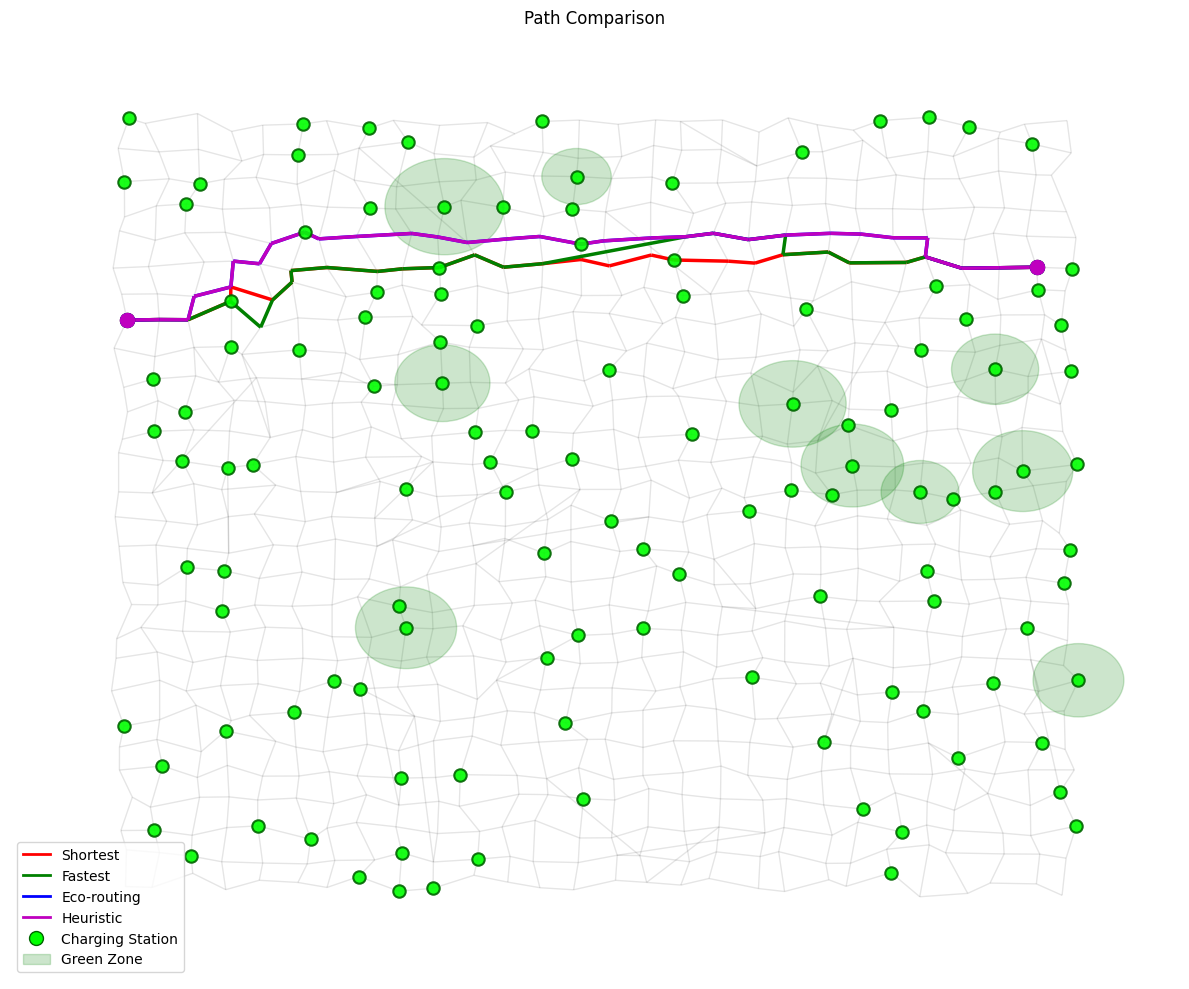

,Distance (km),Time (min),Energy (kWh),Energy Cost ($),Charging Cost ($),V2G Incentives ($),Green Zone Penalties ($),Total Cost ($),Remaining Charge (kWh),Charging Stations
Shortest,31.250000,42.700000,2.430000,1.460000,0,0,14.000000,15.460000,54.780000,0
Fastest,32.630000,40.250000,2.760000,1.660000,0,0,13.000000,14.660000,54.450000,0
Eco-routing,32.390000,50.470000,2.200000,1.320000,0,0,15.000000,16.320000,55.010000,0
Heuristic,32.390000,50.470000,2.200000,1.320000,0,0,15.000000,16.320000,55.010000,0


In [472]:
# Generate a road network
road_network = generate_road_network(num_nodes=800, num_edges=1600,
                                    num_charging_stations=120, num_green_zones=10, seed=42)

# Select a source and destination node
source = 20
target = 750

# Run all routing algorithms with standardized cost calculation
shortest_path, shortest_energy, shortest_metrics = shortest_path_distance(road_network, source, target,VEHICLE_PARAMETERS)
fastest_path, fastest_energy, fastest_metrics = fastest_path_time(road_network, source, target,VEHICLE_PARAMETERS)
eco_path, eco_energy, eco_metrics = eco_routing_algorithm(road_network, source, target,VEHICLE_PARAMETERS)
heuristic_path, heuristic_energy, heuristic_metrics = heuristic_routing_algorithm(road_network, source, target,VEHICLE_PARAMETERS)

# Compare different paths
paths_dict = {
    'Shortest': shortest_path,
    'Fastest': fastest_path,
    'Eco-routing': eco_path,
    'Heuristic': heuristic_path
}

# Visualize the paths
visualize_paths(road_network, paths_dict)

# Compare metrics
metrics_dict = {
    'Shortest': shortest_metrics,
    'Fastest': fastest_metrics,
    'Eco-routing': eco_metrics,
    'Heuristic': heuristic_metrics
}

# Display comparison table
compare_path_metrics(metrics_dict)

In [473]:
def run_batch_comparison(graph, od_pairs, algorithms, vehicle_params=VEHICLE_PARAMETERS):
    """
    Run a batch comparison of multiple routing algorithms across many O-D pairs.

    Parameters:
        graph (nx.Graph): Road network graph
        od_pairs (list): List of (origin, destination) tuples
        algorithms (dict): Dictionary mapping algorithm names to functions
        vehicle_params (dict): Vehicle parameters

    Returns:
        pd.DataFrame: DataFrame with results for all O-D pairs and algorithms
    """
    # Initialize results storage
    results = []

    # Track progress
    total_pairs = len(od_pairs)
    print(f"Starting batch comparison of {len(algorithms)} algorithms on {total_pairs} O-D pairs...")
    start_time = datetime.now()

    # Process each O-D pair
    for i, (origin, destination) in enumerate(od_pairs):
        # Show progress every 100 pairs or at specific percentages
        if (i+1) % 100 == 0 or (i+1) in [1, 10, 50, total_pairs]:
            elapsed = (datetime.now() - start_time).total_seconds()
            est_total = elapsed / (i+1) * total_pairs
            print(f"Progress: {i+1}/{total_pairs} pairs ({((i+1)/total_pairs*100):.1f}%) - "
                  f"Elapsed: {elapsed:.1f}s, Estimated Total: {est_total:.1f}s")

        # Skip pairs that are too close (could cause issues with some algorithms)
        try:
            distance = nx.shortest_path_length(graph, origin, destination, weight='length')
            if distance < 1000:  # Skip if less than 1km
                continue
        except nx.NetworkXNoPath:
            continue

        # Run each algorithm on this O-D pair
        pair_results = {'origin': origin, 'destination': destination, 'pair_id': i}

        for algo_name, algo_func in algorithms.items():
            try:
                # Run algorithm with timeout protection to avoid hanging on complex paths
                path, energy, metrics = algo_func(graph, origin, destination, vehicle_params)

                # Record key metrics
                pair_results[f'{algo_name}_success'] = True
                pair_results[f'{algo_name}_path_length'] = len(path) if path else 0
                pair_results[f'{algo_name}_distance'] = metrics.get('distance', float('inf'))
                pair_results[f'{algo_name}_time'] = metrics.get('time', float('inf'))
                pair_results[f'{algo_name}_energy'] = metrics.get('energy', float('inf'))
                pair_results[f'{algo_name}_energy_cost'] = metrics.get('energy_cost', float('inf'))
                pair_results[f'{algo_name}_running_cost'] = metrics.get('running_cost', 0)
                pair_results[f'{algo_name}_charging_cost'] = metrics.get('charging_cost', 0)
                pair_results[f'{algo_name}_v2g_incentives'] = metrics.get('v2g_incentives', 0)
                pair_results[f'{algo_name}_green_penalties'] = metrics.get('green_zone_penalties', 0)
                pair_results[f'{algo_name}_total_cost'] = metrics.get('total_cost', float('inf'))
                pair_results[f'{algo_name}_remaining_charge'] = metrics.get('remaining_charge', 0)
                pair_results[f'{algo_name}_num_charging'] = len(metrics.get('charging_stations_visited', []))
                pair_results[f'{algo_name}_warning'] = metrics.get('warning', '')

            except Exception as e:
                # Record failure
                pair_results[f'{algo_name}_success'] = False
                pair_results[f'{algo_name}_error'] = str(e)

        # Add to results
        results.append(pair_results)

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    print(f"Batch comparison completed in {(datetime.now() - start_time).total_seconds():.1f} seconds.")
    print(f"Processed {len(results)} valid O-D pairs.")

    return results_df

In [474]:
def save_comparison_results(results_df, filename='routing_comparison_results'):
    """
    Save comparison results to multiple formats for later analysis.

    Parameters:
        results_df (pd.DataFrame): DataFrame with comparison results
        filename (str): Base filename (without extension)

    Returns:
        str: Path to the saved CSV file
    """
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    csv_path = f"{filename}_{timestamp}.csv"
    # excel_path = f"{filename}_{timestamp}.xlsx"
    # pickle_path = f"{filename}_{timestamp}.pkl"

    # Save as CSV (most universal)
    results_df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")

    # # Save as Excel (better formatting)
    # try:
    #     results_df.to_excel(excel_path, index=False)
    #     print(f"Results saved to {excel_path}")
    # except Exception as e:
    #     print(f"Could not save as Excel: {e}")

    # # Save as pickle (preserves all data types, but Python-specific)
    # try:
    #     results_df.to_pickle(pickle_path)
    #     print(f"Results saved to {pickle_path}")
    # except Exception as e:
    #     print(f"Could not save as pickle: {e}")

    return csv_path

In [475]:
def analyze_comparison_results(results_df, algorithms):
    """
    Analyze and visualize comparison results.

    Parameters:
        results_df (pd.DataFrame): DataFrame with comparison results
        algorithms (list): List of algorithm names

    Returns:
        pd.DataFrame: Summary statistics
    """
    print(f"Analyzing results for {len(results_df)} origin-destination pairs...")

    # Filter out pairs where any algorithm failed
    valid_results = results_df.copy()
    for algo in algorithms:
        valid_results = valid_results[valid_results[f'{algo}_success'] == True]

    print(f"Found {len(valid_results)} O-D pairs with valid results for all algorithms.")

    # Calculate summary statistics
    summary = {}
    metrics = ['distance', 'time', 'energy', 'energy_cost', 'running_cost',
               'charging_cost', 'v2g_incentives', 'green_penalties', 'total_cost',
               'remaining_charge', 'num_charging']

    for algo in algorithms:
        summary[algo] = {}
        for metric in metrics:
            col = f'{algo}_{metric}'
            if col in valid_results.columns:
                summary[algo][metric] = {
                    'mean': valid_results[col].mean(),
                    'median': valid_results[col].median(),
                    'min': valid_results[col].min(),
                    'max': valid_results[col].max(),
                    'std': valid_results[col].std()
                }

    # Create summary DataFrame
    summary_df = pd.DataFrame({
        'Algorithm': [],
        'Metric': [],
        'Mean': [],
        'Median': [],
        'Min': [],
        'Max': [],
        'Std Dev': []
    })

    for algo in algorithms:
        for metric in metrics:
            if metric in summary[algo]:
                summary_df = pd.concat([summary_df, pd.DataFrame({
                    'Algorithm': [algo],
                    'Metric': [metric],
                    'Mean': [summary[algo][metric]['mean']],
                    'Median': [summary[algo][metric]['median']],
                    'Min': [summary[algo][metric]['min']],
                    'Max': [summary[algo][metric]['max']],
                    'Std Dev': [summary[algo][metric]['std']]
                })], ignore_index=True)

    # Calculate relative performance (normalized to Shortest path)
    relative_perf = {}
    baseline_algo = 'Shortest'  # Use shortest path as baseline

    for metric in ['distance', 'time', 'energy', 'total_cost']:
        relative_perf[metric] = {}
        baseline_mean = valid_results[f'{baseline_algo}_{metric}'].mean()

        for algo in algorithms:
            if algo != baseline_algo:
                algo_mean = valid_results[f'{algo}_{metric}'].mean()
                relative_perf[metric][algo] = ((algo_mean / baseline_mean) - 1) * 100  # percent change

    # Create visualizations
    # 1. Bar chart of mean total cost by algorithm
    plt.figure(figsize=(12, 6))
    algo_costs = [valid_results[f'{algo}_total_cost'].mean() for algo in algorithms]
    plt.bar(algorithms, algo_costs, color=['blue', 'orange', 'green', 'red'])
    plt.title('Mean Total Cost by Algorithm')
    plt.ylabel('Cost ($)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, cost in enumerate(algo_costs):
        plt.text(i, cost + 0.5, f'${cost:.2f}', ha='center')
    plt.tight_layout()
    plt.show()

    # 2. Comparative bar chart for multiple metrics
    metrics_to_plot = ['distance', 'time', 'energy', 'total_cost']
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics_to_plot):
        metric_values = {}
        for algo in algorithms:
            metric_values[algo] = valid_results[f'{algo}_{metric}'].mean()

        ax = axes[i]
        ax.bar(list(metric_values.keys()), list(metric_values.values()))

        # Format y-axis based on metric
        if metric == 'distance':
            ax.set_title('Mean Distance (m)')
            # Convert to km for display
            for j, v in enumerate(metric_values.values()):
                ax.text(j, v + (max(metric_values.values())*0.02), f'{v/1000:.2f} km', ha='center')
        elif metric == 'time':
            ax.set_title('Mean Time (seconds)')
            # Convert to minutes for display
            for j, v in enumerate(metric_values.values()):
                ax.text(j, v + (max(metric_values.values())*0.02), f'{v/60:.2f} min', ha='center')
        elif metric == 'energy':
            ax.set_title('Mean Energy (kWh)')
            for j, v in enumerate(metric_values.values()):
                ax.text(j, v + (max(metric_values.values())*0.02), f'{v:.2f} kWh', ha='center')
        else:
            ax.set_title(f'Mean {metric.title().replace("_", " ")}')
            for j, v in enumerate(metric_values.values()):
                ax.text(j, v + (max(metric_values.values())*0.02), f'${v:.2f}', ha='center')

        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # 3. Table of relative performance compared to shortest path
    relative_df = pd.DataFrame(columns=['Metric'] + [algo for algo in algorithms if algo != baseline_algo])

    for metric in relative_perf:
        row = {'Metric': metric.title()}
        for algo in algorithms:
            if algo != baseline_algo:
                row[algo] = f"{relative_perf[metric][algo]:.2f}%"
        relative_df = pd.concat([relative_df, pd.DataFrame([row])], ignore_index=True)

    # print("\nRelative Performance (% change from Shortest Path):")
    # display(relative_df)

    # Return detailed summary
    return summary_df

In [476]:
def run_comprehensive_evaluation(num_od_pairs=2000, min_distance=3000, save_results=True):
    """
    Run a comprehensive evaluation of all routing algorithms on a large number of O-D pairs.

    Parameters:
        num_od_pairs (int): Number of origin-destination pairs to test
        min_distance (float): Minimum distance between origin and destination
        save_results (bool): Whether to save results to files

    Returns:
        tuple: (results_df, summary_df) with raw results and summary statistics
    """
    print(f"Current Date and Time (UTC): {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Current User's Login: kripa-sindhu-007")
    print(f"\nStarting comprehensive evaluation with {num_od_pairs} O-D pairs...\n")

    # Generate road network
    print("Generating road network...")
    road_network = generate_road_network(num_nodes=400, num_edges=1200,
                                         num_charging_stations=30, num_green_zones=5, seed=42)
    print(f"Network generated with {road_network.number_of_nodes()} nodes and {road_network.number_of_edges()} edges.")

    # Select random O-D pairs
    print(f"\nSelecting {num_od_pairs} random O-D pairs with minimum distance of {min_distance}m...")
    od_pairs = select_random_od_pairs(road_network, num_pairs=num_od_pairs, min_distance=min_distance)
    print(f"Selected {len(od_pairs)} valid O-D pairs.")

    # Define algorithms to compare
    algorithms = {
        'Shortest': shortest_path_distance,
        'Fastest': fastest_path_time,
        'Eco': eco_routing_algorithm,
        'Heuristic': heuristic_routing_algorithm
    }

    # Run batch comparison
    print("\nRunning batch comparison...")
    results_df = run_batch_comparison(road_network, od_pairs, algorithms, VEHICLE_PARAMETERS)

    # Save results if requested
    if save_results:
        print("\nSaving results...")
        save_comparison_results(results_df, 'ev_routing_comparison')

    # Analyze results
    print("\nAnalyzing results...")
    summary_df = analyze_comparison_results(results_df, list(algorithms.keys()))

    print("\nEvaluation complete!")
    return results_df, summary_df

Current Date and Time (UTC): 2025-03-27 06:08:12
Current User's Login: kripa-sindhu-007

Starting comprehensive evaluation with 2000 O-D pairs...

Generating road network...
Network generated with 400 nodes and 869 edges.

Selecting 2000 random O-D pairs with minimum distance of 2000m...
Selecting 2000 O-D pairs with minimum distance of 2000 meters...
  Progress: 5/2000 pairs found
  Progress: 10/2000 pairs found
  Progress: 15/2000 pairs found
  Progress: 20/2000 pairs found
  Progress: 25/2000 pairs found
  Progress: 30/2000 pairs found
  Progress: 35/2000 pairs found
  Progress: 40/2000 pairs found
  Progress: 45/2000 pairs found
  Progress: 50/2000 pairs found
  Progress: 55/2000 pairs found
  Progress: 60/2000 pairs found
  Progress: 65/2000 pairs found
  Progress: 70/2000 pairs found
  Progress: 75/2000 pairs found
  Progress: 80/2000 pairs found
  Progress: 85/2000 pairs found
  Progress: 90/2000 pairs found
  Progress: 95/2000 pairs found
  Progress: 100/2000 pairs found
  Prog

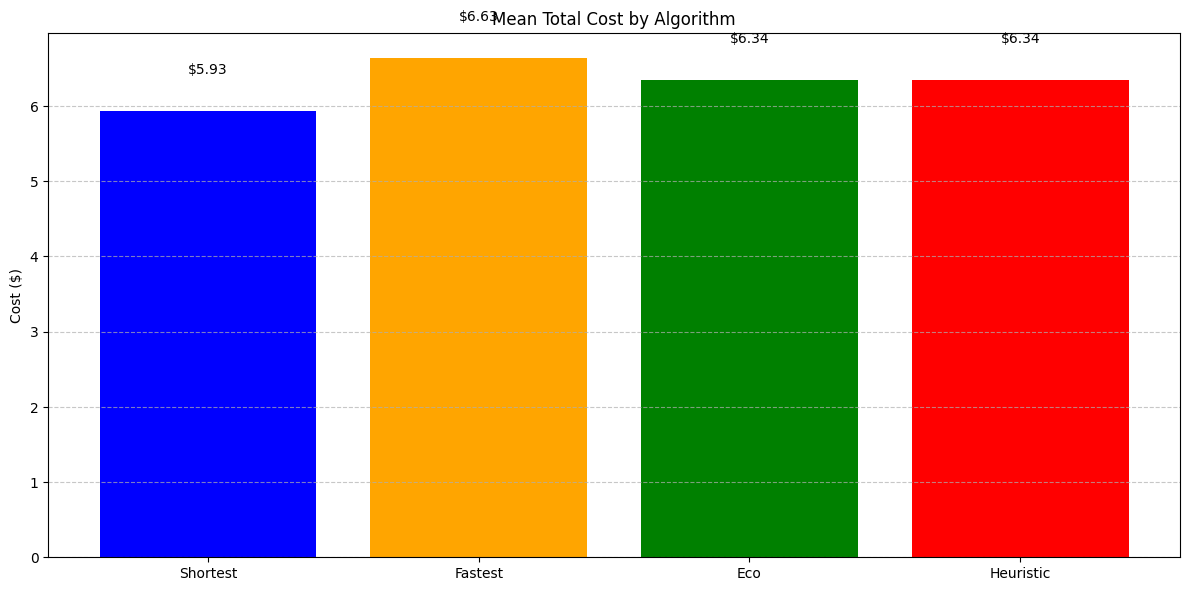

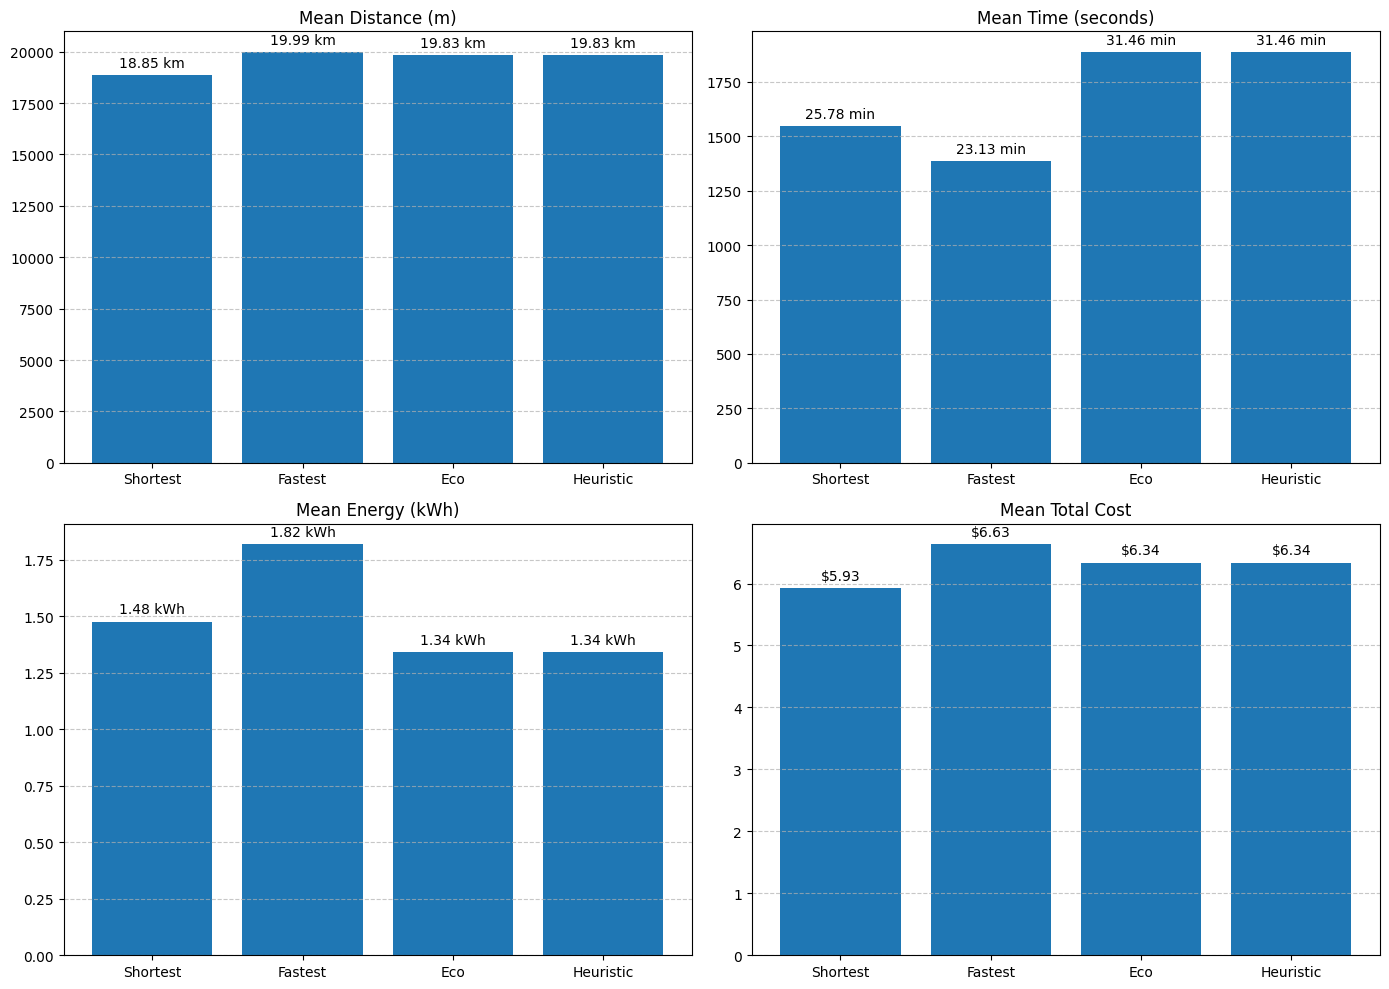


Evaluation complete!


In [477]:
results_df, summary_df = run_comprehensive_evaluation(num_od_pairs=2000, min_distance=2000)